# Loading libraries

In [1]:
import glob2 as glob
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

import pandas as pd
pd.option_context("display.max_columns", None)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Loading file

In [2]:
path= '/content/drive/MyDrive/Research/IBM Advanced Data Science/'

final_clean = pd.read_csv(path + 'sim_final_clean_train.csv')
final_clean.head()

,timestamp2,user_at,experiment,id,kitchen,living,main,study
0,0.0,kitchen,1,1.0,-52.701716,-74.780561,-83.300811,-71.631284
1,1.0,kitchen,1,2.0,-52.637074,-74.760833,-83.382558,-71.553430
2,2.0,kitchen,1,3.0,-52.574323,-74.740637,-83.463088,-71.476892
3,3.0,kitchen,1,4.0,-52.513155,-74.720056,-83.543619,-71.401618
4,4.0,kitchen,1,5.0,-52.453652,-74.699391,-83.624817,-71.327123


In [3]:
final_clean['user_at'].unique()

array(['kitchen', 'living', 'main', 'study'], dtype=object)

# Converting categories for target

In [4]:
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical

le = preprocessing.LabelEncoder()
le.fit(final_clean['user_at'].unique())
final_clean['user_at_cat'] = le.transform(final_clean['user_at'])
final_clean.head()

,timestamp2,user_at,experiment,id,kitchen,living,main,study,user_at_cat
0,0.0,kitchen,1,1.0,-52.701716,-74.780561,-83.300811,-71.631284,0
1,1.0,kitchen,1,2.0,-52.637074,-74.760833,-83.382558,-71.553430,0
2,2.0,kitchen,1,3.0,-52.574323,-74.740637,-83.463088,-71.476892,0
3,3.0,kitchen,1,4.0,-52.513155,-74.720056,-83.543619,-71.401618,0
4,4.0,kitchen,1,5.0,-52.453652,-74.699391,-83.624817,-71.327123,0


In [5]:
list(le.classes_)

['kitchen', 'living', 'main', 'study']

# Scaling features

In [6]:
from sklearn import preprocessing
scale_columns = ['kitchen', 'living', 'main', 'study']

scaler = preprocessing.RobustScaler()
X_train = scaler.fit_transform(final_clean[scale_columns])
X_train

array([[ 1.76252697, -0.09283092, -0.67532814, -0.23406901],
       [ 1.76759586, -0.09059616, -0.68203933, -0.22361153],
       [ 1.77251654, -0.08830844, -0.68865067, -0.21333062],
       ...,
       [-0.15540437, -0.98254812, -0.16780767,  2.06369192],
       [-0.16554636, -0.97774064, -0.17037195,  2.06948253],
       [-0.17614907, -0.97267792, -0.1729523 ,  2.07591025]])

In [7]:
X_train.shape

(972, 4)

In [8]:
y_train = to_categorical(final_clean['user_at_cat'])

In [9]:
y_train.shape

(972, 4)

# Preparing testing data

In [10]:
orig_df = pd.read_csv('/content/drive/MyDrive/Research/IBM Advanced Data Science/finalDataFrame_simulations.csv')
orig_df.head()

X_testDF_or = orig_df[orig_df['experiment'].isin([4, 5])]
X_testDF_or.head()

,name,rssi,timestamp,experiment,user_at
12000,kitchen1,-59.130547,1.0,4,kitchen
12001,kitchen1,-54.807857,2.0,4,kitchen
12002,kitchen1,-56.788439,3.0,4,kitchen
12003,kitchen1,-42.996534,4.0,4,kitchen
12004,kitchen1,-49.187477,5.0,4,kitchen


In [11]:
X_testDF_or['user_at'].unique()

array(['kitchen', 'living', 'main', 'study'], dtype=object)

In [12]:
X_testDF_or.shape

(32000, 5)

In [13]:
X_test_pre = X_testDF_or.copy()

In [14]:
X_test_pre['timestamp2'] = round((X_test_pre['timestamp'] * 100)/500)
X_test_pre['beacon_at'] = [string[:-1] for string in X_test_pre['name']]
X_test_pre.head()

,name,rssi,timestamp,experiment,user_at,timestamp2,beacon_at
12000,kitchen1,-59.130547,1.0,4,kitchen,0.0,kitchen
12001,kitchen1,-54.807857,2.0,4,kitchen,0.0,kitchen
12002,kitchen1,-56.788439,3.0,4,kitchen,1.0,kitchen
12003,kitchen1,-42.996534,4.0,4,kitchen,1.0,kitchen
12004,kitchen1,-49.187477,5.0,4,kitchen,1.0,kitchen


In [15]:
X_test = X_test_pre.pivot_table(values='rssi', columns = 'beacon_at', index=['timestamp2', 'user_at', 'experiment'], aggfunc = 'median')
X_test = X_test.reset_index()
X_test.head()

beacon_at,timestamp2,user_at,experiment,kitchen,living,main,study
0,0.0,kitchen,4,-54.477287,-68.225214,-83.106741,-70.274548
1,0.0,kitchen,5,-50.624351,-72.530347,-83.584936,-68.768741
2,0.0,living,4,-68.878396,-57.214302,-75.203295,-79.880144
3,0.0,living,5,-70.107908,-55.109374,-72.885698,-77.578171
4,0.0,main,4,-82.989132,-73.876634,-51.287492,-69.058940


In [16]:
X_test["kitchen"] = X_test['kitchen'].fillna(X_test.groupby('user_at')['kitchen'].transform('median'))
X_test["living"] = X_test['living'].fillna(X_test.groupby('user_at')['living'].transform('median'))
X_test["main"] = X_test['main'].fillna(X_test.groupby('user_at')['main'].transform('median'))
X_test["study"] = X_test['study'].fillna(X_test.groupby('user_at')['study'].transform('median'))

X_test.sort_values(by=['user_at', 'experiment', 'timestamp2'], inplace=True)
X_test.reset_index(drop=True, inplace=True)
X_test = X_test.rename_axis(None, axis=1)
X_test['id'] = X_test.groupby('experiment')['experiment'].rank(method='first')
X_test.head()

,timestamp2,user_at,experiment,kitchen,living,main,study,id
0,0.0,kitchen,4,-54.477287,-68.225214,-83.106741,-70.274548,1.0
1,1.0,kitchen,4,-49.593312,-72.388199,-81.433290,-69.884945,2.0
2,2.0,kitchen,4,-49.172596,-73.826341,-81.494691,-69.510522,3.0
3,3.0,kitchen,4,-51.208413,-77.080105,-86.790000,-72.944836,4.0
4,4.0,kitchen,4,-53.505001,-74.628603,-84.931035,-69.379560,5.0


In [17]:
X_test_clean = X_test[['timestamp2', 'user_at', 'experiment', 'id']].copy()
X_test_clean[['kitchen', 'living', 'main', 'study']] = 0
X_test_clean.tail()

,timestamp2,user_at,experiment,id,kitchen,living,main,study
643,76.0,study,5,320.0,0,0,0,0
644,77.0,study,5,321.0,0,0,0,0
645,78.0,study,5,322.0,0,0,0,0
646,79.0,study,5,323.0,0,0,0,0
647,80.0,study,5,324.0,0,0,0,0


In [18]:
ba = X_test_pre['beacon_at'].unique().tolist()
fi = X_test_clean['experiment'].unique().tolist()
ua = X_test['user_at'].unique().tolist()

for beacon in ba:
  for exp in fi:
    for userat in ua:
      tmp = X_test.loc[(X_test['experiment']==exp)&(X_test['user_at']==userat), ['id', beacon]]
      res = sm.nonparametric.lowess(tmp.iloc[:,1], tmp.iloc[:,0], frac = 1./3)
      res_loess = list(res[:,1])
      X_test_clean.loc[tmp.index, beacon] = res_loess

X_test_clean.head()

,timestamp2,user_at,experiment,id,kitchen,living,main,study
0,0.0,kitchen,4,1.0,-51.663462,-73.780124,-82.960575,-70.416157
1,1.0,kitchen,4,2.0,-51.685141,-73.821332,-83.029543,-70.364815
2,2.0,kitchen,4,3.0,-51.704483,-73.858549,-83.095672,-70.312934
3,3.0,kitchen,4,4.0,-51.721126,-73.892983,-83.159246,-70.260896
4,4.0,kitchen,4,5.0,-51.735460,-73.925952,-83.221044,-70.209283


In [19]:
X_test_clean['user_at_cat'] = le.transform(X_test_clean['user_at'])
X_test_clean.head()

,timestamp2,user_at,experiment,id,kitchen,living,main,study,user_at_cat
0,0.0,kitchen,4,1.0,-51.663462,-73.780124,-82.960575,-70.416157,0
1,1.0,kitchen,4,2.0,-51.685141,-73.821332,-83.029543,-70.364815,0
2,2.0,kitchen,4,3.0,-51.704483,-73.858549,-83.095672,-70.312934,0
3,3.0,kitchen,4,4.0,-51.721126,-73.892983,-83.159246,-70.260896,0
4,4.0,kitchen,4,5.0,-51.735460,-73.925952,-83.221044,-70.209283,0


In [20]:
columns = ['kitchen', 'living', 'main', 'study']
X_test_f = scaler.fit_transform(X_test_clean[columns])
X_test_f

array([[ 1.74509828,  0.04251718, -0.65508724, -0.05661429],
       [ 1.74345005,  0.03706434, -0.66098924, -0.04966825],
       [ 1.74197949,  0.03213963, -0.66664827, -0.04264933],
       ...,
       [-0.18498748, -1.24499362, -0.12134219,  2.12818949],
       [-0.18966965, -1.25274317, -0.12367847,  2.13542331],
       [-0.19474437, -1.26055631, -0.12631571,  2.14256575]])

In [21]:
y_test = to_categorical(X_test_clean['user_at_cat'])
y_test

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

# Starting modeling

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, LSTM, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [23]:
#del model

In [24]:
callback = EarlyStopping(monitor='loss', patience=3)

model = Sequential()
model.add(Dense(4, activation='relu', input_dim=4))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.2))
#model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='sigmoid', kernel_initializer='random_normal'))

#Compiling the neural network
model.compile(optimizer ='adam', loss='binary_crossentropy', metrics =['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 20        
                                                                 
 dense_1 (Dense)             (None, 128)               640       
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 4)                 260       
                                                                 
Total params: 25,688
Trainable params: 25,688
Non-traina

In [25]:
print(X_train.shape)
print(y_train.shape)
print(X_test_f.shape)
print(y_test.shape)


(972, 4)
(972, 4)
(648, 4)
(648, 4)


In [26]:
#Fitting the data to the training dataset
history = model.fit(X_train, y_train, batch_size=10, epochs=100, callbacks=[callback], validation_data = (X_test_f, y_test))

Epoch 1/100
98/98 [==============================] - 2s 5ms/step - loss: 0.3673 - accuracy: 0.8385 - val_loss: 0.0309 - val_accuracy: 1.0000
Epoch 2/100
98/98 [==============================] - 0s 4ms/step - loss: 0.0100 - accuracy: 1.0000 - val_loss: 6.9656e-04 - val_accuracy: 1.0000
Epoch 3/100
98/98 [==============================] - 0s 3ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.8075e-04 - val_accuracy: 1.0000
Epoch 4/100
98/98 [==============================] - 0s 4ms/step - loss: 6.4727e-04 - accuracy: 1.0000 - val_loss: 7.3901e-05 - val_accuracy: 1.0000
Epoch 5/100
98/98 [==============================] - 0s 3ms/step - loss: 4.9591e-04 - accuracy: 1.0000 - val_loss: 3.5025e-05 - val_accuracy: 1.0000
Epoch 6/100
98/98 [==============================] - 0s 4ms/step - loss: 3.4937e-04 - accuracy: 1.0000 - val_loss: 2.0144e-05 - val_accuracy: 1.0000
Epoch 7/100
98/98 [==============================] - 0s 4ms/step - loss: 2.5006e-04 - accuracy: 1.0000 - val_loss: 9.9979e

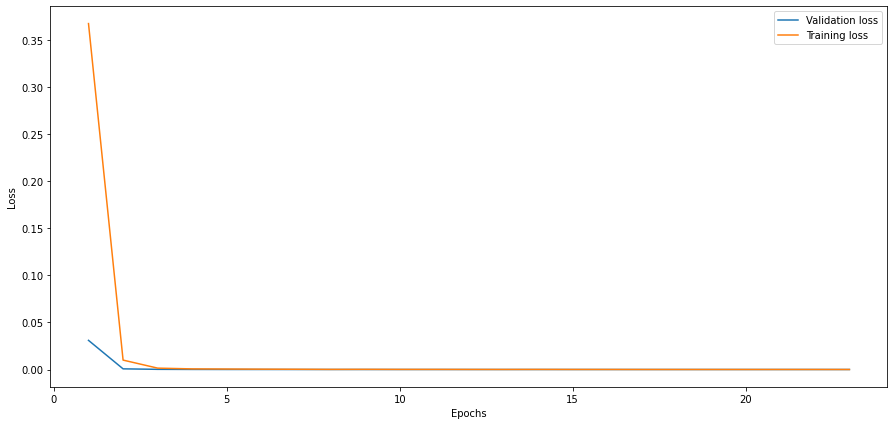

In [27]:
# accuracy = history.history['accuracy']
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(15, 7))
plt.plot(epochs, val_loss_values, label='Validation loss')
plt.plot(epochs, loss_values, label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
y_hat = model.predict(X_test_f)
y_hat = (y_hat > 0.5)
y_hat

array([[ True, False, False, False],
       [ True, False, False, False],
       [ True, False, False, False],
       ...,
       [False, False, False,  True],
       [False, False, False,  True],
       [False, False, False,  True]])

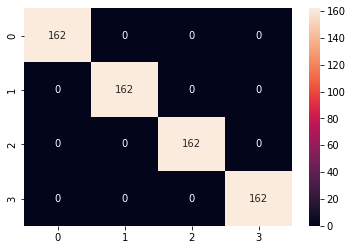

In [29]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_hat.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g')

In [30]:
from sklearn.metrics import balanced_accuracy_score, hamming_loss
balanced_accuracy_score(y_test.argmax(axis=1), y_hat.argmax(axis=1))


1.0

In [31]:
hamming_loss(y_test.argmax(axis=1), y_hat.argmax(axis=1))

0.0

## Trial 2

In [32]:
del model 

from tensorflow.keras.optimizers import SGD

model = Sequential()
model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

history = model.fit(X_train, y_train,epochs=100,batch_size=10,callbacks=[callback], validation_data = (X_test_f, y_test))

Epoch 1/100
98/98 [==============================] - 1s 5ms/step - loss: 0.3618 - accuracy: 0.9156 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 2/100
98/98 [==============================] - 0s 3ms/step - loss: 0.0094 - accuracy: 1.0000 - val_loss: 5.9652e-04 - val_accuracy: 1.0000
Epoch 3/100
98/98 [==============================] - 0s 3ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 2.3041e-04 - val_accuracy: 1.0000
Epoch 4/100
98/98 [==============================] - 0s 3ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 1.3731e-04 - val_accuracy: 1.0000
Epoch 5/100
98/98 [==============================] - 0s 2ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 9.0674e-05 - val_accuracy: 1.0000
Epoch 6/100
98/98 [==============================] - 0s 2ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 6.2856e-05 - val_accuracy: 1.0000
Epoch 7/100
98/98 [==============================] - 0s 3ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 5.0184e-05 - val_accura

In [33]:
#model.save('/content/drive/MyDrive/Research/IBM Advanced Data Science/sim_predicting_location.h5')

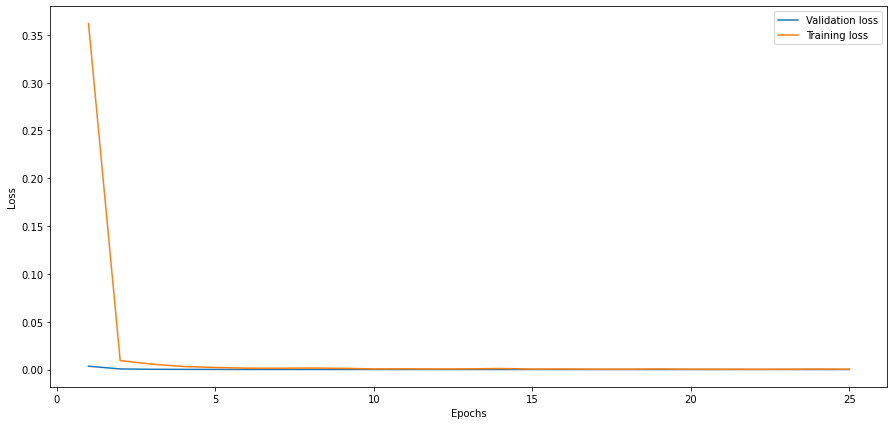

In [34]:
# accuracy = history.history['accuracy']
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(15, 7))
plt.plot(epochs, val_loss_values, label='Validation loss')
plt.plot(epochs, loss_values, label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [35]:
y_hat = model.predict(X_test_f)
y_hat = (y_hat > 0.5)
y_hat

array([[ True, False, False, False],
       [ True, False, False, False],
       [ True, False, False, False],
       ...,
       [False, False, False,  True],
       [False, False, False,  True],
       [False, False, False,  True]])

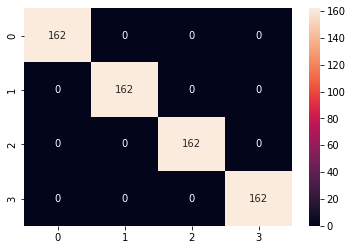

In [36]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_hat.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g')

In [37]:
from sklearn.metrics import balanced_accuracy_score, hamming_loss
balanced_accuracy_score(y_test.argmax(axis=1), y_hat.argmax(axis=1))

1.0

In [38]:
hamming_loss(y_test.argmax(axis=1), y_hat.argmax(axis=1))

0.0

# Test 3

In [39]:
callback = EarlyStopping(monitor='loss', patience=3)

model = Sequential()
model.add(Dense(4, activation='relu', input_dim=4))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.2))
#model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='softmax'))

#Compiling the neural network
model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics =['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 4)                 20        
                                                                 
 dense_10 (Dense)            (None, 128)               640       
                                                                 
 dense_11 (Dense)            (None, 128)               16512     
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 4)                 260       
                                                                 
Total params: 25,688
Trainable params: 25,688
Non-trai

In [40]:
#Fitting the data to the training dataset
history = model.fit(X_train, y_train, batch_size=10, epochs=100, callbacks=[callback], validation_data = (X_test_f, y_test))

Epoch 1/100
98/98 [==============================] - 2s 8ms/step - loss: 0.5769 - accuracy: 0.9434 - val_loss: 0.0205 - val_accuracy: 1.0000
Epoch 2/100
98/98 [==============================] - 1s 11ms/step - loss: 0.0075 - accuracy: 1.0000 - val_loss: 8.1517e-04 - val_accuracy: 1.0000
Epoch 3/100
98/98 [==============================] - 0s 4ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 2.2020e-04 - val_accuracy: 1.0000
Epoch 4/100
98/98 [==============================] - 0s 3ms/step - loss: 6.6779e-04 - accuracy: 1.0000 - val_loss: 1.0083e-04 - val_accuracy: 1.0000
Epoch 5/100
98/98 [==============================] - 0s 3ms/step - loss: 4.4334e-04 - accuracy: 1.0000 - val_loss: 5.6572e-05 - val_accuracy: 1.0000
Epoch 6/100
98/98 [==============================] - 0s 3ms/step - loss: 3.1423e-04 - accuracy: 1.0000 - val_loss: 3.3762e-05 - val_accuracy: 1.0000
Epoch 7/100
98/98 [==============================] - 0s 3ms/step - loss: 2.5946e-04 - accuracy: 1.0000 - val_loss: 1.9411

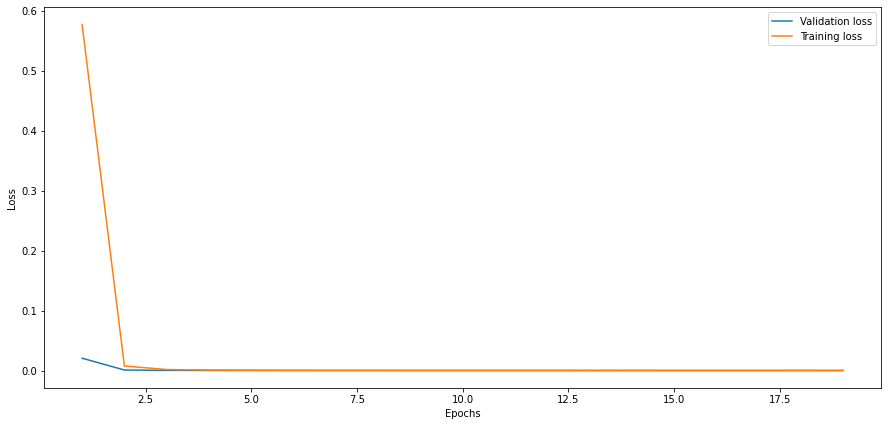

In [42]:
# accuracy = history.history['accuracy']
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(15, 7))
plt.plot(epochs, val_loss_values, label='Validation loss')
plt.plot(epochs, loss_values, label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [43]:
y_hat = model.predict(X_test_f)
y_hat = (y_hat > 0.5)
y_hat

array([[ True, False, False, False],
       [ True, False, False, False],
       [ True, False, False, False],
       ...,
       [False, False, False,  True],
       [False, False, False,  True],
       [False, False, False,  True]])

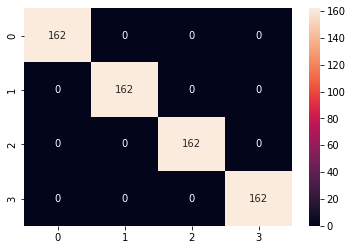

In [44]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_hat.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g')

In [45]:
from sklearn import metrics
print('Accuracy Score:', metrics.accuracy_score(y_test.argmax(axis=1), y_hat.argmax(axis=1)))
print('Balanced Accuracy Score:', metrics.balanced_accuracy_score(y_test.argmax(axis=1), y_hat.argmax(axis=1)))

Accuracy Score: 1.0
Balanced Accuracy Score: 1.0


In [46]:
model.save('/content/drive/MyDrive/Research/IBM Advanced Data Science/sim_predicting_location_test3.h5')